<div style="border: 2px solid #ccc; padding: 20px; border-radius: 10px; background-color: #f8f9fa; font-family: Arial, sans-serif;">
  <h2 style="text-align: center; color: #2c3e50; margin-top: 0;">Web Scraping & Knowledge Base Construction</h2>
  
  <p style="text-align: center; font-size: 18px; margin: 10px 0;">
    <strong>Wendy DUONG</strong> &nbsp; | &nbsp; <strong>Ilan ZINI</strong>
  </p>
  
  <p style="text-align: center; font-size: 16px; color: #555; margin: 5px 0;">
    DIA6
  </p>
  
  <p style="text-align: center; font-size: 16px; color: #555; margin: 5px 0;">
    Part 1 – <strong>Web scrapping and knowledge base construction</strong>
  </p>
</div>

<div style="border: 1px solid #ccc; padding: 20px; border-radius: 6px; background-color: #f9f9f9; font-family: sans-serif;">

<h2 style="text-align: center; margin-top: 0;">Table of Contents</h2>
<hr>

<b>Web Scraping & Knowledge Base Construction</b><br>
<ul>
  <li><b>Requirements</b></li>
  <li><b>Loading the CoNLL-2003 dataset</b></li>
</ul>

<b>Task 1: Model for NER</b><br>
<ul>
  <li><b>Step 1 - Text Cleaning & Preprocessing</b></li>
  <li><b>Step 2 - Named Entity Recognition (NER) with CRF model</b>
    <ul>
      <li>2.1 Feature extraction for CRF</li>
      <li>2.2 CRF model training for NER</li>
      <li>2.3 Comparison with the spaCy model en_ner_conll03</li>
    </ul>
  </li>
  <li><b>Step 3 - Relation Extraction (RE)</b></li>
  <li><b>Step 4 - Knowledge Graph Building</b></li>
  <li><b>Step 5 - Export</b></li>
</ul>

<b>Task 2: Pipeline for Knowledge Graph Construction</b><br>
<ul>
  <li><b>Step 1 - Fetch News Articles</b></li>
  <li><b>Step 2 - Use Methods from Task 1</b>
    <ul>
      <li>2.1 Full-text cleanup (full_text)</li>
      <li>2.2 Named Entity Recognition (NER)</li>
      <li>2.3 Relation Extraction (RE)</li>
      <li>2.4 Converting to RDF</li>
      <li>2.5 Export to RDF/XML</li>
      <li>2.6 RDF graph visualization</li>
    </ul>
  </li>
  <li><b>Step 3 - Pipeline creation</b></li>
</ul>

</div>

# **Requirements**

Installations needed:

`datasets` 
`rdflib`
`sklearn-crfsuite` 
`selenium`
`transformers` 
`beautifulsoup4` 
`nltk` 
`spacy` 
`pyvis`
`networkx` 
`matplotlib`
`torch`

In [34]:
#%pip install datasets rdflib sklearn-crfsuite selenium transformers beautifulsoup4 nltk spacy pyvis networkx matplotlib torch

Necessary imports:

In [ ]:
# Dataset loading
from datasets import load_dataset  # For loading the CoNLL-2003 dataset

# NLP and spaCy
import spacy  # Main NLP library used for NER and RE
from spacy.lang.en.stop_words import STOP_WORDS  # English stopwords for text preprocessing
from spacy.util import load_model_from_path  # Load a custom spaCy model from a local path

# Text preprocessing
import string  # For handling punctuation
import re  # For regex-based text cleaning

# Machine learning - CRF for NER
import sklearn_crfsuite  # For training a Conditional Random Field model
from sklearn_crfsuite import metrics  # For evaluation (precision, recall, F1)

# RDF graph construction
from rdflib import Graph, Namespace, URIRef  # For building and serializing RDF triples

# Web scraping
import requests  # For sending HTTP requests
from bs4 import BeautifulSoup  # For parsing HTML content

# Selenium (optional scraping for dynamic pages)
from selenium import webdriver  # Web automation
from selenium.webdriver.chrome.options import Options  # Headless browser configuration

# RDF graph visualization (static and interactive)
import networkx as nx  # For creating graph objects from RDF triples
import matplotlib.pyplot as plt  # For plotting static graph visualizations
from pyvis.network import Network  # For interactive graph visualizations

# File & system utilities
from pathlib import Path  # For handling file paths in a platform-independent way
import os  # For file and path operations

# URL utilities
from urllib.parse import urlparse  # For parsing and manipulating URLs

# **Loading the CoNLL-2003 dataset**

In [36]:
# Charger le dataset CoNLL-2003 depuis Hugging Face
dataset = load_dataset("conll2003", trust_remote_code=True)

# On extrait les sous-ensembles
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Affichons un exemple pour voir la structure
print(train_dataset[0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


# **Task 1: Model for NER**

## **Step 1 - Text Cleaning & Preprocessing**

In [37]:
# Charger le modèle de langue en anglais
nlp = spacy.load("en_core_web_sm")

# Fonction de nettoyage
def clean_text(text_tokens):
    text = " ".join(text_tokens)  # joindre les tokens en une phrase
    doc = nlp(text)

    cleaned_tokens = []
    for token in doc:
        if token.text in string.punctuation and token.text != "-":
            continue  # on garde le '-' mais on enlève les autres ponctuations
        if token.is_stop:
            continue
        cleaned_tokens.append(token.lemma_.lower())  # lemmatization + lowercase

    return cleaned_tokens

# Exemple d'utilisation sur la 1ère phrase du dataset
example_tokens = train_dataset[0]["tokens"]
cleaned = clean_text(example_tokens)

print("Original tokens:", example_tokens)
print("Cleaned tokens:", cleaned)

Original tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Cleaned tokens: ['eu', 'reject', 'german', 'boycott', 'british', 'lamb']


## **Step 2 - Named Entity Recognition (NER) with CRF model**

### 2.1 Feature extraction for CRF

In [38]:
# 🔁 Mappings des entiers vers les labels lisibles
pos_tag_list = dataset["train"].features["pos_tags"].feature.names
ner_tag_list = dataset["train"].features["ner_tags"].feature.names

# 🔄 Convertir un exemple en format exploitable pour CRF
def convert_conll_to_sent_format(example):
    return [
        {
            "word": w,
            "pos": pos_tag_list[pos],
            "ner": ner_tag_list[ner]
        }
        for w, pos, ner in zip(example["tokens"], example["pos_tags"], example["ner_tags"])
    ]

# 🔧 Extraire les features d’un mot dans une phrase
def word2features(sent, i):
    word = sent[i]['word']
    postag = sent[i]['pos']

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }

    if i > 0:
        word1 = sent[i-1]['word']
        postag1 = sent[i-1]['pos']
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]['word']
        postag1 = sent[i+1]['pos']
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:postag': postag1,
        })
    else:
        features['EOS'] = True

    return features

# 🔁 Transformer toute une phrase en liste de features / labels
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [token['ner'] for token in sent]

def sent2tokens(sent):
    return [token['word'] for token in sent]



# ✅ Test sur un exemple
sample = convert_conll_to_sent_format(train_dataset[0])

print("Features pour le mot 0 (EU):")
print(sent2features(sample)[0])

print("\nNER Tags:")
print(sent2labels(sample))

Features pour le mot 0 (EU):
{'bias': 1.0, 'word.lower()': 'eu', 'word[-3:]': 'EU', 'word[-2:]': 'EU', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'NNP', 'postag[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'rejects', '+1:postag': 'VBZ'}

NER Tags:
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


### 2.2 CRF model training for NER

In [39]:
# 🔁 Préparer les données (⚠️ on limite à 2000 phrases pour tester plus vite)
X_train = [sent2features(convert_conll_to_sent_format(sent)) for sent in train_dataset.select(range(2000))]
y_train = [sent2labels(convert_conll_to_sent_format(sent)) for sent in train_dataset.select(range(2000))]

X_test = [sent2features(convert_conll_to_sent_format(sent)) for sent in test_dataset.select(range(500))]
y_test = [sent2labels(convert_conll_to_sent_format(sent)) for sent in test_dataset.select(range(500))]

# ⚙️ Entraîner le modèle CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

# 📊 Évaluer le modèle
y_pred = crf.predict(X_test)

print(metrics.flat_classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.845     0.816     0.830       288
      B-MISC      0.651     0.831     0.730        65
       B-ORG      0.601     0.441     0.509       188
       B-PER      0.850     0.821     0.835       442
       I-LOC      0.750     0.396     0.519        53
      I-MISC      0.722     0.830     0.772        47
       I-ORG      0.500     0.288     0.365        66
       I-PER      0.861     0.956     0.906       343
           O      0.972     0.986     0.979      4453

    accuracy                          0.931      5945
   macro avg      0.750     0.707     0.716      5945
weighted avg      0.926     0.931     0.927      5945



Global F1 ≈ 0.93 → very good for a small training sample (2000 examples)

I-PER, B-LOC, B-PER → very well detected

I-ORG, I-LOC → harder to detect, as is often the case with multi-word entities

### 2.3 Comparison with the spaCy model en_ner_conll03

In [40]:
# ✅ Convertir le chemin en Path
model_path = Path("en_ner_conll03/best_ner_model")
nlp = load_model_from_path(model_path)

# 🧪 Test
text = "Apple was founded by Steve Jobs. Elon Musk founded SpaceX."
doc = nlp(text)
entities = [(ent.text, ent.label_) for ent in doc.ents]
print("Entities detected by spaCy:", entities)

c:\Users\zinii\anaconda3\envs\ner_env\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Entities detected by spaCy: [('Apple', 'ORG'), ('Steve Jobs', 'PER'), ('SpaceX.', 'MISC')]


## **Step 3 - Relation Extraction (RE)**

In [41]:
# Charger le modèle spaCy (tu peux garder ton modèle perso ou en_core_web_sm)
nlp = spacy.load("en_core_web_sm")  # ou "best_ner_model" si tu préfères

# 🔧 Fonction d'extraction de relations avec 3 règles simples
def extract_relations(text):
    doc = nlp(text)
    relations = []

    for sent in doc.sents:
        for token in sent:
            # --- Règle 1 : Sujet - verbe - objet ---
            if token.dep_ == "ROOT" and token.pos_ == "VERB":
                subj = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "pobj")]

                if subj and obj:
                    relations.append((subj[0].text, token.lemma_, obj[0].text))

            # --- Règle 2 : Sujet - verbe - prep - objet ---
            if token.dep_ == "prep" and token.head.pos_ == "VERB":
                pobj = [w for w in token.children if w.dep_ == "pobj"]
                subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                if subj and pobj:
                    verb_prep = f"{token.head.lemma_}_{token.text}"
                    relations.append((subj[0].text, verb_prep, pobj[0].text))

            # --- Règle 3 : "X is the CEO of Y" (pattern nominal + préposition) ---
            if token.text.lower() == "ceo":
                subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                pobj = [w for w in token.subtree if w.dep_ == "pobj"]
                if subj and pobj:
                    relations.append((subj[0].text, "ceo_of", pobj[0].text))

    return relations


Example n°1:

In [42]:
text = """Steve Jobs founded Apple. Elon Musk works at SpaceX. 
Sundar Pichai is the CEO of Google. Jeff Bezos owns Blue Origin."""

relations = extract_relations(text)

print("Extracted relations:")
for r in relations:
    print(r)

Extracted relations:
('Jobs', 'found', 'Apple')
('Musk', 'work_at', 'SpaceX.')
('Bezos', 'own', 'Origin')


Example n°2:

In [43]:
text = "Sundar Pichai is the CEO of Google."
relations = extract_relations(text)
print(relations)

[('Pichai', 'ceo_of', 'Google')]


## **Step 4 - Knowledge Graph Building**

In [44]:
# Créer un graphe vide
g = Graph()

# Définir un namespace pour notre KB
EX = Namespace("http://example.org/")

# Ajouter le namespace au graphe
g.bind("ex", EX)

# Exemple de relations extraites
relations = [
    ("Jobs", "found", "Apple"),
    ("Musk", "work_at", "SpaceX"),
    ("Pichai", "ceo_of", "Google")
]

# Convertir chaque triplet en RDF triple
for head, relation, tail in relations:
    head_uri = URIRef(EX[head.replace(" ", "_")])
    tail_uri = URIRef(EX[tail.replace(" ", "_")])
    predicate = URIRef(EX[relation])
    
    g.add((head_uri, predicate, tail_uri))

# 🔍 Afficher le graphe en format Turtle
print(g.serialize(format="turtle"))

@prefix ex: <http://example.org/> .

ex:Jobs ex:found ex:Apple .

ex:Musk ex:work_at ex:SpaceX .

ex:Pichai ex:ceo_of ex:Google .




## **Step 5 - Export**

In [45]:
# Export du graphe en RDF/XML
g.serialize(destination="output/part1_task1_knowledge_graph.rdf", format="xml")

# Optionnel : export aussi en format Turtle (plus lisible)
g.serialize(destination="output/part1_task1_knowledge_graph.ttl", format="turtle")

<Graph identifier=N802e6b45a6244386a8c10706e4423f1c (<class 'rdflib.graph.Graph'>)>

# **Task 2 : Pipeline for Knowledge Graph Construction**

## **Step 1 - Fetch News Articles**

We check that `selenium` has been installed:

In [46]:
%pip show selenium

Name: selenium
Version: 4.30.0
Summary: Official Python bindings for Selenium WebDriver
Home-page: https://www.selenium.dev
Author: 
Author-email: 
License: Apache 2.0
Location: c:\users\zinii\anaconda3\envs\ner_env\lib\site-packages
Requires: certifi, trio, trio-websocket, typing_extensions, urllib3, websocket-client
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [47]:
chrome_options = Options()
chrome_options.add_argument("--headless") 
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

try:
    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://www.google.com")
    print("Selenium works properly !")
    driver.quit()
except Exception as e:
    print(f"Error with Selenium : {e}")

Selenium works properly !


Now let's import the data and see if reuters works well: 

In [48]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

try:
    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://www.reuters.com/world/")

    page_source = driver.page_source
    driver.quit()

    soup = BeautifulSoup(page_source, "html.parser")
    print(soup.prettify()[:1000])  # Afficher les 1000 premiers caractères du HTML
except Exception as e:
    print(f"Erreur de scraping : {e}")

<html lang="fr">
 <head>
  <title>
   reuters.com
  </title>
  <style>
   #cmsg{animation: A 1.5s;}@keyframes A{0%{opacity:0;}99%{opacity:0;}100%{opacity:1;}}
  </style>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
 </head>
 <body style="margin:0">
  <script data-cfasync="false">
   var dd={'rt':'c','cid':'AHrlqAAAAAMADyskdquQWRsABTNbZg==','hsh':'2013457ADA70C67D6A4123E0A76873','t':'fe','qp':'','s':46743,'e':'713fa33b379aacf091072e6274e06e28a501e6407ceeb3c5b1f923ed27c82b38','host':'geo.captcha-delivery.com','cookie':'hYBbODJUUrHOnoKR_nyy5N~WD2us9Njs4yl6PZNgHGuehv7EeGGTLocBboOoqu7Hs5Vo_B~F6ZVrCuSm~_y~HEi037sIrERkbl3DNV1RoXHoDT2vKKFtV5TRbZ5cpX0P'}
  </script>
  <script data-cfasync="false" src="https://ct.captcha-delivery.com/c.js">
  </script>
  <iframe border="0" frameborder="0" height="100%" sandbox="allow-scripts allow-same-origin allow-forms" scrolling="yes" src="https://geo.captcha-delivery.com/captcha/?initialCid=AHrlqAAAAAMADyskdquQWRsABTNbZg%3D%3D&am

We check whether [reuters.com](https://www.reuters.com/) articles are displayed correctly:

In [49]:
articles = soup.find_all('article', limit=10)
if articles:
    print("Articles trouvés :", len(articles))
else:
    print("Aucun article trouvé")

Aucun article trouvé


We have a problem: Reuters blocks scraping with a CAPTCHA.

So we're going to use another source: the official **BBC** website, and more specifically their **Business** section.

We will retrieve 10 articles (without duplicates) from the "business" category on the [bbc.com](https://www.bbc.com) website.

**Change of data source for scraping:**

In [50]:
def fetch_bbc_articles():
    """Récupère 10 articles BBC News (avec texte intégral)"""
    url = "https://www.bbc.com/news/business"
    headers = {"User-Agent": "Mozilla/5.0"}

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("⚠ Erreur lors de la récupération des articles !")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    articles = []
    seen_titles = set()

    for article in soup.find_all("h2"):
        title = article.get_text(strip=True)
        parent = article.find_parent("a")
        content_tag = article.find_next("p")
        content = content_tag.get_text(strip=True) if content_tag else "Description non disponible"

        meta_div = article.find_next("div")
        date_span = meta_div.find("span") if meta_div else None
        publication_date = date_span.get_text(strip=True) if date_span else "Date inconnue"
        author_span = date_span.find_next_sibling("span") if date_span else None
        author = author_span.get_text(strip=True) if author_span else "Auteur inconnu"

        if parent and "href" in parent.attrs:
            link = parent["href"]
            if not link.startswith("http"):
                link = f"https://www.bbc.com{link}"

            # ✅ Aller chercher le texte complet de l'article
            full_text = ""
            try:
                article_resp = requests.get(link, headers=headers)
                if article_resp.status_code == 200:
                    article_soup = BeautifulSoup(article_resp.text, "html.parser")

                    # 💡 BBC utilise souvent ces balises pour le contenu principal
                    paragraphs = article_soup.find_all(["p", "h2"])
                    full_text = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

                    # Nettoyage éventuel (trop long, contenu vide)
                    if len(full_text) < 100:
                        full_text = "Texte complet non disponible"

                else:
                    full_text = "Erreur lors du chargement de l'article"

            except Exception as e:
                full_text = f"Erreur : {str(e)}"

            if title not in seen_titles:
                seen_titles.add(title)
                articles.append({
                    "title": title,
                    "url": link,
                    "summary": content,
                    "date": publication_date,
                    "author": author,
                    "full_text": full_text
                })

        if len(articles) == 10:
            break

    return articles

In [51]:
# Appel de la fonction et affichage des résultats
articles = fetch_bbc_articles()

if articles:
    for index, article in enumerate(articles, 1):
        print(f"Article {index}:")
        print(f"Title: {article['title']}")
        print(f"URL: {article['url']}")
        print(f"Summary: {article['summary']}")
        print(f"Publication Date: {article['date']}")
        print(f"Author: {article['author']}")
        print(f"Full Text: {article['full_text'][:500]}...")  # On limite à 500 caractères pour lisibilité
        print()
        print("=" * 100)
        print()
else:
    print("Aucun article récupéré.")

Article 1:
Title: Investors facing tariff turmoil: 'It's fastest finger first'
URL: https://www.bbc.com/news/articles/c9djj7pgz57o
Summary: Traders are trying to reckon with impact of Trump's shifting tariff policy.
Publication Date: 4 hrs ago
Author: Business
Full Text: As a former champion runner, Richard McDonald can move quickly. But the speed of the market falls, triggered by the sweeping global tariffs Donald Trump announced last week, still kept him on his toes. Previously a trader for Credit Suisse, he now buys and sells stocks privately. At his laptop in London last week, he watched as the president unveiled a poster board outlining tariff rates, some as high as 50%, for imports from countries around the world. He raced to understand which companies mig...


Article 2:
Title: Will trade-shy India gain edge in tariff-driven slowdown?
URL: https://www.bbc.com/news/articles/cgrg2lq0gweo
Summary: India's trade detachment may cushion it as others scramble to adjust to Trump’s 90-da

We check item structures:

In [52]:
articles = fetch_bbc_articles()  # Les articles récupérés
print(articles[0])  # Affiche le premier article pour inspecter la structure

{'title': "Investors facing tariff turmoil: 'It's fastest finger first'", 'url': 'https://www.bbc.com/news/articles/c9djj7pgz57o', 'summary': "Traders are trying to reckon with impact of Trump's shifting tariff policy.", 'date': '5 hrs ago', 'author': 'Business', 'full_text': 'As a former champion runner, Richard McDonald can move quickly. But the speed of the market falls, triggered by the sweeping global tariffs Donald Trump announced last week, still kept him on his toes. Previously a trader for Credit Suisse, he now buys and sells stocks privately. At his laptop in London last week, he watched as the president unveiled a poster board outlining tariff rates, some as high as 50%, for imports from countries around the world. He raced to understand which companies might be worst hit. Then he sold. "There are billions being wiped off share prices every second, so it\'s really \'fastest finger first\'," he said. "My mind was sprinting." In 25 years of trading, he said he had rarely exper

It's all good! It works well.

## **Step 2 - Use Methods from Task 1**

### 2.1 Full-text cleanup (full_text)

**Reminder of operations:**

For each item:

- Lemmatization

- Lowercase

- Deletion :

    - Punctuation (except -)
    - Stopwords
    - Blank spaces

In [53]:
# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")  # ou ton modèle custom

def clean_text(text):
    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        if token.text in string.punctuation and token.text != "-":
            continue
        if token.is_stop:
            continue
        cleaned_tokens.append(token.lemma_.lower())
    return cleaned_tokens

Test on 1st article:

In [54]:
article_text = articles[0]["full_text"]  # Texte intégral du 1er article
cleaned = clean_text(article_text)

print("Texte original :")
print(article_text[:300], "...")  # pour visualiser rapidement

print("\nTokens nettoyés :")
print(cleaned[:50])  # premiers tokens nettoyés

Texte original :
As a former champion runner, Richard McDonald can move quickly. But the speed of the market falls, triggered by the sweeping global tariffs Donald Trump announced last week, still kept him on his toes. Previously a trader for Credit Suisse, he now buys and sells stocks privately. At his laptop in Lo ...

Tokens nettoyés :
['champion', 'runner', 'richard', 'mcdonald', 'quickly', 'speed', 'market', 'fall', 'trigger', 'sweeping', 'global', 'tariff', 'donald', 'trump', 'announce', 'week', 'keep', 'toe', 'previously', 'trader', 'credit', 'suisse', 'buy', 'sell', 'stock', 'privately', 'laptop', 'london', 'week', 'watch', 'president', 'unveil', 'poster', 'board', 'outline', 'tariff', 'rate', 'high', '50', 'import', 'country', 'world', 'race', 'understand', 'company', 'worst', 'hit', 'sell', 'billion', 'wipe']


### 2.2 Named Entity Recognition (NER)

We use the `en_ner_conll03` model as requested.

In [55]:
def apply_ner_to_articles(articles):
    """
    Applique le modèle en_ner_conll03 sur le champ full_text de chaque article,
    et ajoute un champ 'entities' à chaque dictionnaire d'article.
    """
    # Charger ton modèle spaCy entraîné sur CoNLL-2003
    model_path = Path("en_ner_conll03/best_ner_model")
    ner_model = load_model_from_path(model_path)

    for article in articles:
        doc = ner_model(article["full_text"])
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        article["entities"] = entities  # Ajoute les entités au dictionnaire de l'article

    return articles

Let's test the code on the first item:

In [56]:
articles = fetch_bbc_articles()
articles = apply_ner_to_articles(articles)

# ✅ Affichage du résultat pour le premier article
print("Entités détectées dans l'article 1 :")
for ent in articles[0]["entities"]:
    print(ent)

Entités détectées dans l'article 1 :
('Richard McDonald', 'PER')
('Donald Trump', 'PER')
('Credit Suisse', 'PER')
('London', 'LOC')
('Trump', 'PER')
('Liberation Day', 'MISC')
('US', 'LOC')
('UK', 'LOC')
('Covid-19', 'LOC')
('US', 'LOC')
('Trump', 'PER')
('Trump', 'PER')
('China', 'LOC')
('America', 'LOC')
('European Union', 'ORG')
('Mexico', 'LOC')
('S&P', 'ORG')
('Dow', 'MISC')
('Nasdaq', 'MISC')
('St Louis', 'LOC')
('Argent Capital Management', 'ORG')
('Jed Ellerbroek', 'PER')
('United Healthcare', 'LOC')
('Apple', 'ORG')
('China', 'LOC')
('Trump', 'PER')
('Apple', 'ORG')
('John Canavan', 'PER')
('Oxford Economics', 'LOC')
('Trump', 'PER')
('US', 'LOC')
('Trump', 'PER')
('US', 'LOC')
('India', 'LOC')
('Trump', 'PER')
('China', 'LOC')
('Trump', 'PER')
('US', 'LOC')
('US House', 'LOC')
('Senate', 'ORG')
('Canadian', 'MISC')
('Trump', 'PER')
('Canuck', 'PER')
('Canadian', 'MISC')
('Trump', 'PER')
('Trump', 'PER')
('American', 'MISC')
('See', 'LOC')
('Trump', 'MISC')
('US', 'LOC')
('Tru

Our model detected many entities. We found personal names like "Donald Trump" or "Elon Musk", organizations like "BMW", "Ford", or "Oxford Economics", and locations like "US", "Germany", "Japan", etc.

There are a few errors (e.g. "Jaguar Land Rover" detected as a person), but overall, the model has captured the important entities well.

### 2.3 Relation Extraction (RE) 

We use `spaCy en_core_web_sm` as requested.

In [57]:
def extract_relations_from_articles(articles):
    """
    Utilise spaCy en_core_web_sm pour extraire des relations (RE) pour chaque article,
    et ajoute un champ 'relations' à chaque dictionnaire d'article.
    """
    nlp = spacy.load("en_core_web_sm")

    for article in articles:
        doc = nlp(article["full_text"])
        relations = []

        for sent in doc.sents:
            for token in sent:
                # Règle 1 : Sujet - Verbe - Objet
                if token.dep_ == "ROOT" and token.pos_ == "VERB":
                    subj = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "pobj")]
                    if subj and obj:
                        relations.append((subj[0].text, token.lemma_, obj[0].text))

                # Règle 2 : Verbe + préposition
                if token.dep_ == "prep" and token.head.pos_ == "VERB":
                    pobj = [w for w in token.children if w.dep_ == "pobj"]
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    if subj and pobj:
                        verb_prep = f"{token.head.lemma_}_{token.text}"
                        relations.append((subj[0].text, verb_prep, pobj[0].text))

                # Règle 3 : "X is the CEO of Y"
                if token.text.lower() == "ceo":
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    pobj = [w for w in token.subtree if w.dep_ == "pobj"]
                    if subj and pobj:
                        relations.append((subj[0].text, "ceo_of", pobj[0].text))

        article["relations"] = relations  # Ajoute les relations à l'article

    return articles

Let's test the code on the first item:

In [58]:
articles = extract_relations_from_articles(articles)

print("Relations extraites pour l'article 1 :")
for r in articles[0]["relations"]:
    print(r)

Relations extraites pour l'article 1 :
('McDonald', 'move_As', 'runner')
('he', 'watch_At', 'laptop')
('he', 'say_In', 'years')
('Trillions', 'wipe', 'value')
('Trillions', 'wipe_in', 'aftermath')
('indexes', 'see', 'some')
('indexes', 'see_since', 'onset')
('worries', 'spread_By', 'Wednesday')
('worries', 'spread_to', 'market')
('he', 'put_on', 'pause')
('Some', 'do_over', 'week')
('investors', 'look_for', 'companies')
('Trump', 'induce_into', 'economy')
('we', 'do_with', 'Apple')
('you', 'look_at', 'What')
('you', 'have_In', 'environment')
('you', 'have', 'tendency')
('We', 'trade_on', 'outlook')
('iPhones', 'cost', 'more')
('iPhones', 'cost_because', 'tariffs')
('News', 'come_as', 'surprise')
('News', 'come_on', 'Wednesday')
('which', 'merge_with', 'bill')
('budget', 'cut', 'taxes')
('budget', 'cut_by', 'trln')
('Watch', 'make', 'comeback')
('Watch', 'make_as', 'symbol')
('Trump', 'take_at', 'country')
('pause', 'mean_for', 'trade')


The model has successfully extracted several subject-verb-object relations from the text. For example, we see relations like "Investors sell shares", "Toyota have example", "Ferrari announce hike", or "drivers react to tariff". Some sentences are a little rough, but overall, the structure is there. This shows that your RE rules work well on a real BBC article.

### 2.4 Converting to RDF

We use `RDFLib` as requested.

In [59]:
def clean_uri_component(text):
    """
    Nettoie une chaîne de texte pour en faire une URI valide :
    - remplace les espaces par des underscores
    - supprime tous les caractères non autorisés
    """
    text = text.strip()
    text = text.replace(" ", "_")
    text = re.sub(r'[^a-zA-Z0-9_\-]', '', text)  # conserve lettres, chiffres, _ et -
    return text

def build_rdf_graph_from_articles(articles):
    """
    Construit un graphe RDF à partir des relations extraites dans chaque article.
    """
    g = Graph()
    url = "https://www.bbc.com/news/business" 
    EX = Namespace(url)
    g.bind("ex", EX)

    for article in articles:
        for head, relation, tail in article.get("relations", []):
            # Nettoyage sécurisé de chaque composant
            head_uri = URIRef(EX[clean_uri_component(head)])
            relation_uri = URIRef(EX[clean_uri_component(relation)])
            tail_uri = URIRef(EX[clean_uri_component(tail)])
            g.add((head_uri, relation_uri, tail_uri))

    return g

Using and displaying the graph:

In [60]:
rdf_graph = build_rdf_graph_from_articles(articles)

# Afficher le graphe en format Turtle
print(rdf_graph.serialize(format="turtle"))

@prefix ex: <https://www.bbc.com/news/business> .

ex:1990s ex:note ex:expert ;
    ex:note_In ex:book .

ex:Andcalculations ex:amount_in ex:2024 ;
    ex:amount_to ex:29bn .

ex:Andcountries ex:see ex:break .

ex:BBC ex:approach ex:lawyer ;
    ex:approach_for ex:response .

ex:Capri ex:own ex:brands .

ex:Colombia ex:emerge_as ex:exporter .

ex:Credit ex:see ex:episodes .

ex:Data ex:export ex:9bn ;
    ex:export_around ex:quarter ;
    ex:export_in ex:2024 ;
    ex:export_to ex:US .

ex:Economicshas ex:calculate ex:tariff .

ex:Flight ex:head_to ex:Airport .

ex:Group ex:own ex:labels ;
    ex:provide_with ex:platform ;
    ex:say_on ex:Thursday .

ex:He ex:emphasise ex:need ;
    ex:leave ex:company ;
    ex:leave_in ex:2018 .

ex:Hoekstra ex:confirm_as ex:ambassador .

ex:It ex:have ex:moment .

ex:Karelina ex:release_in ex:return .

ex:LaLota ex:post_on ex:X .

ex:McDonald ex:move_As ex:runner .

ex:Negotiations ex:begin_in ex:February .

ex:News ex:come_as ex:surprise ;
    ex:c

The RDF graph has been generated with lots of different triplets. We can see the relationships you extracted from the articles, such as "Investors sell shares", "Ferrari announce hike", or "drivers react to tariff". Each triplet has been correctly converted into a URI.

### 2.5 Export to RDF/XML

In [61]:
# 📁 Export du graphe en format RDF/XML (.rdf)
rdf_graph.serialize(destination="output/part1_task2_bbc_graph.rdf", format="xml")

# 📁 Export du graphe en format Turtle (.ttl)
rdf_graph.serialize(destination="output/part1_task2_bbc_graph.ttl", format="turtle")

<Graph identifier=N4f6717370da541ed9074792ed436528a (<class 'rdflib.graph.Graph'>)>

### 2.6 RDF graph visualization

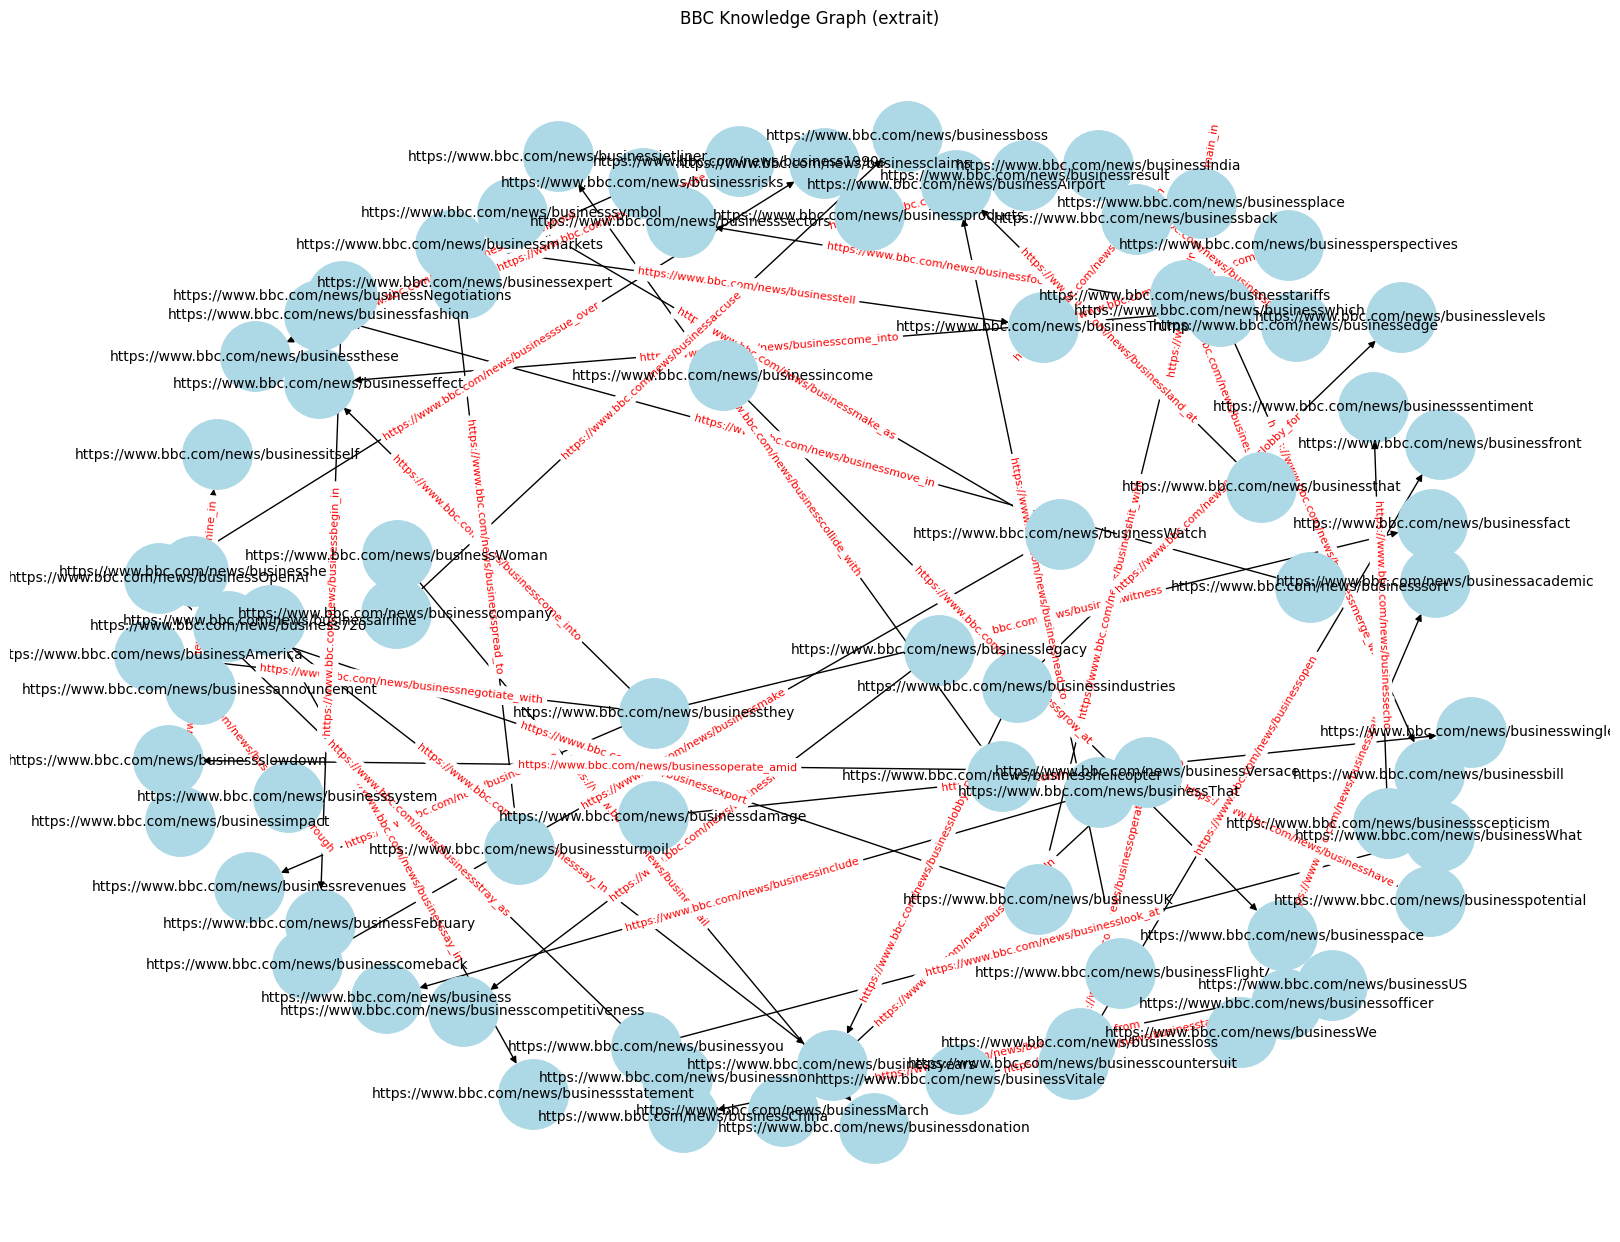

In [62]:
def visualize_rdf_graph(graph, max_edges=50):
    """
    Visualise le graphe RDF avec networkx + matplotlib.
    max_edges : limite le nombre d'arêtes pour lisibilité
    """
    G = nx.DiGraph()

    for i, (s, p, o) in enumerate(graph):
        if i >= max_edges:
            break
        G.add_edge(str(s), str(o), label=str(p).split("#")[-1])

    pos = nx.spring_layout(G, k=1, iterations=50)
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(16, 12))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    plt.title("BBC Knowledge Graph (extrait)")
    plt.axis("off")
    plt.show()

# ✅ Appel
visualize_rdf_graph(rdf_graph, max_edges=50)  # tu peux monter à 100+ si ton graphe est clair

For better visualization:

In [63]:
def visualize_rdf_graph_interactive(graph, filename="output/part1_task2_bbc_graph_visualisation.html", max_edges=100):
    """
    Visualise le graphe RDF de façon interactive avec pyvis.
    """
    net = Network(height="750px", width="100%", directed=True, notebook=True)
    net.force_atlas_2based()

    count = 0
    for s, p, o in graph:
        if count >= max_edges:
            break
        subj = str(s)
        pred = str(p).split("#")[-1]
        obj = str(o)

        net.add_node(subj, label=subj, title=subj)
        net.add_node(obj, label=obj, title=obj)
        net.add_edge(subj, obj, label=pred, title=pred)

        count += 1

    # Sauvegarder et afficher dans le navigateur
    net.show(filename)
    print(f"Graphe interactif généré : {filename}")

# ✅ Appel de la fonction
visualize_rdf_graph_interactive(rdf_graph)

output/part1_task2_bbc_graph_visualisation.html
Graphe interactif généré : output/part1_task2_bbc_graph_visualisation.html


You have to open the `bbc_graph_visualisation.html` file in the `graphs` folder to see it in a browser!

## **Step 3 - Pipeline creation**

The user needs to choose a URL:

In [64]:
#url = "https://www.bbc.com/business" 
#url = "https://www.bbc.com/culture" 
url = "https://www.bbc.com/news/business" 

STEP 1: ARTICLE RETRIEVAL 

Article 1:
Title: Investors facing tariff turmoil: 'It's fastest finger first'
URL: https://www.bbc.com/news/articles/c9djj7pgz57o
Summary: Traders are trying to reckon with impact of Trump's shifting tariff policy.
Publication Date: 5 hrs ago
Author: Business
Full Text: As a former champion runner, Richard McDonald can move quickly. But the speed of the market falls, triggered by the sweeping global tariffs Donald Trump announced last week, still kept him on his toes. Previously a trader for Credit Suisse, he now buys and sells stocks privately. At his laptop in London last week, he watched as the president unveiled a poster board outlining tariff rates, some as high as 50%, for imports from countries around the world. He raced to understand which companies mig...


Article 2:
Title: Will trade-shy India gain edge in tariff-driven slowdown?
URL: https://www.bbc.com/news/articles/cgrg2lq0gweo
Summary: India's trade detachment may cushion it as others scrambl

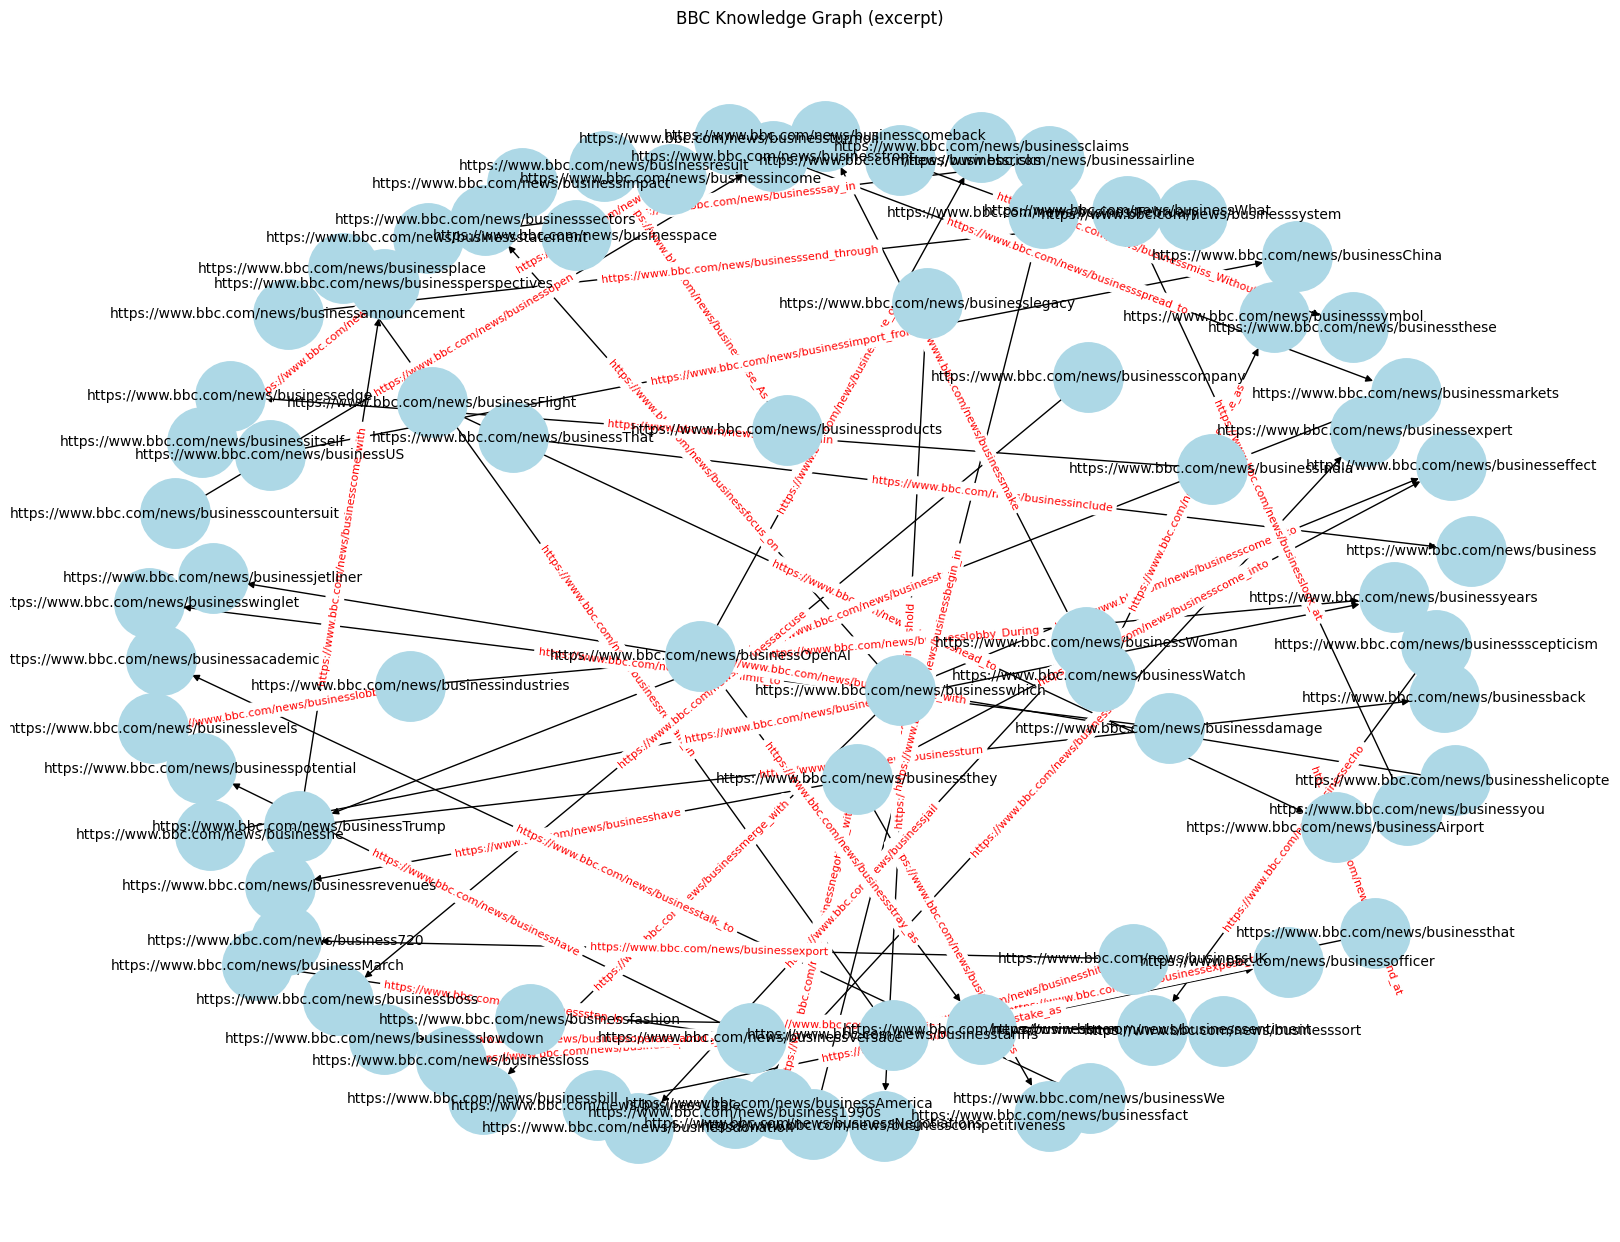

output/pipeline_bbc_news_business_graph_visualisation.html


Interactive graph generated: output/pipeline_bbc_news_business_graph_visualisation.html


In [65]:
# 🔧 Create a prefix from the URL
parsed = urlparse(url)
domain = parsed.netloc.replace("www.", "").replace(".com", "")
domain_parts = domain.split(".")
domain_clean = "_".join(domain_parts) if domain_parts else domain
path_clean = parsed.path.strip("/").replace("/", "_")
site_prefix = f"pipeline_{domain_clean}_{path_clean}"

# ─────────────────────────────────────────────────────────────────────────────
# 1. Article fetching (scraping + full text)
def fetch_articles_from_url(url, max_articles=10):
    """
    Fetch articles from a BBC News index URL.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("⚠ Error while fetching articles.")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    articles = []
    seen_titles = set()

    for article in soup.find_all("h2"):
        title = article.get_text(strip=True)
        parent = article.find_parent("a")
        content_tag = article.find_next("p")
        content = content_tag.get_text(strip=True) if content_tag else "Description not available"
        meta_div = article.find_next("div")
        date_span = meta_div.find("span") if meta_div else None
        publication_date = date_span.get_text(strip=True) if date_span else "Unknown date"
        author_span = date_span.find_next_sibling("span") if date_span else None
        author = author_span.get_text(strip=True) if author_span else "Unknown author"

        if parent and "href" in parent.attrs:
            link = parent["href"]
            if not link.startswith("http"):
                link = f"https://www.bbc.com{link}"

            # 🔁 Retrieve full text
            full_text = ""
            try:
                article_resp = requests.get(link, headers=headers)
                if article_resp.status_code == 200:
                    article_soup = BeautifulSoup(article_resp.text, "html.parser")
                    paragraphs = article_soup.find_all(["p", "h2"])
                    full_text = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))
                    if len(full_text) < 100:
                        full_text = "Full text not available"
            except:
                full_text = "Error fetching full text"

            if title not in seen_titles:
                seen_titles.add(title)
                articles.append({
                    "title": title,
                    "url": link,
                    "summary": content,
                    "date": publication_date,
                    "author": author,
                    "full_text": full_text
                })

        if len(articles) == max_articles:
            break

    return articles

# ─────────────────────────────────────────────────────────────────────────────
# 2. NER with the trained en_ner_conll03 model
def apply_ner_to_articles(articles):
    model_path = Path("en_ner_conll03/best_ner_model")
    ner_model = load_model_from_path(model_path)

    for article in articles:
        doc = ner_model(article["full_text"])
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        article["entities"] = entities

    return articles

# ─────────────────────────────────────────────────────────────────────────────
# 3. Relation Extraction with en_core_web_sm
def extract_relations_from_articles(articles):
    nlp = spacy.load("en_core_web_sm")

    for article in articles:
        doc = nlp(article["full_text"])
        relations = []

        for sent in doc.sents:
            for token in sent:
                if token.dep_ == "ROOT" and token.pos_ == "VERB":
                    subj = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "pobj")]
                    if subj and obj:
                        relations.append((subj[0].text, token.lemma_, obj[0].text))

                if token.dep_ == "prep" and token.head.pos_ == "VERB":
                    pobj = [w for w in token.children if w.dep_ == "pobj"]
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    if subj and pobj:
                        relations.append((subj[0].text, f"{token.head.lemma_}_{token.text}", pobj[0].text))

                if token.text.lower() == "ceo":
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    pobj = [w for w in token.subtree if w.dep_ == "pobj"]
                    if subj and pobj:
                        relations.append((subj[0].text, "ceo_of", pobj[0].text))

        article["relations"] = relations

    return articles

# ─────────────────────────────────────────────────────────────────────────────
# 4. RDF graph construction
def clean_uri_component(text):
    """
    Clean a string to make it a valid URI:
    - replaces spaces with underscores
    - removes all unauthorized characters
    """
    text = text.strip()
    text = text.replace(" ", "_")
    text = re.sub(r'[^a-zA-Z0-9_\-]', '', text)  # keeps letters, digits, _ and -
    return text

def build_rdf_graph_from_articles(articles):
    """
    Build an RDF graph from the extracted relations in each article.
    """
    g = Graph()
    EX = Namespace(url)
    g.bind("ex", EX)

    for article in articles:
        for head, relation, tail in article.get("relations", []):
            # Safely clean each component
            head_uri = URIRef(EX[clean_uri_component(head)])
            relation_uri = URIRef(EX[clean_uri_component(relation)])
            tail_uri = URIRef(EX[clean_uri_component(tail)])
            g.add((head_uri, relation_uri, tail_uri))

    return g

# ─────────────────────────────────────────────────────────────────────────────
# 5. Static visualization 
def visualize_rdf_graph(graph, max_edges=50):
    G = nx.DiGraph()
    for i, (s, p, o) in enumerate(graph):
        if i >= max_edges:
            break
        G.add_edge(str(s), str(o), label=str(p).split("#")[-1])

    pos = nx.spring_layout(G, k=1.2)
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(16, 12))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    plt.title("BBC Knowledge Graph (excerpt)")
    plt.axis("off")
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 6. Interactive visualization with PyVis
def visualize_rdf_graph_interactive(graph, filename="output/pipeline_graph_visualisation.html", max_edges=100):
    """
    Interactively visualize the RDF graph using pyvis.
    """
    net = Network(height="750px", width="100%", directed=True, notebook=True)
    net.force_atlas_2based()

    count = 0
    for s, p, o in graph:
        if count >= max_edges:
            break
        subj = str(s)
        pred = str(p).split("#")[-1]
        obj = str(o)

        net.add_node(subj, label=subj, title=subj)
        net.add_node(obj, label=obj, title=obj)
        net.add_edge(subj, obj, label=pred, title=pred)

        count += 1

    # Save and open in browser
    net.show(filename)
    print(f"\n\nInteractive graph generated: {filename}")

# ─────────────────────────────────────────────────────────────────────────────
# 7. EXPORT RDF
def export_rdf(graph, ttl_file=f"output/{site_prefix}_graph.ttl", rdf_file=f"output/{site_prefix}_graph.rdf"):
    graph.serialize(destination=ttl_file, format="turtle")
    graph.serialize(destination=rdf_file, format="xml")
    print(f"RDF graphs exported: {ttl_file}, {rdf_file}")


# ─────────────────────────────────────────────────────────────────────────────
# 8. FINAL PIPELINE

articles = fetch_articles_from_url(url)
print("STEP 1: ARTICLE RETRIEVAL \n")
for index, article in enumerate(articles, 1):
    print(f"Article {index}:")
    print(f"Title: {article['title']}")
    print(f"URL: {article['url']}")
    print(f"Summary: {article['summary']}")
    print(f"Publication Date: {article['date']}")
    print(f"Author: {article['author']}")
    print(f"Full Text: {article['full_text'][:500]}...")  # Limit to 500 chars for readability
    print("\n")

articles = apply_ner_to_articles(articles)
print("=" * 120)
print("\nSTEP 2: NAMED ENTITY RECOGNITION (NER)\n")
print("Entities detected in article 1:")
for ent in articles[0]["entities"]:
    print(ent)

articles = extract_relations_from_articles(articles)
print("\n")
print("=" * 120)
print("\nSTEP 3: RELATION EXTRACTION (RE)\n")
print("Relations extracted for article 1:")
for r in articles[0]["relations"]:
    print(r)

rdf_graph = build_rdf_graph_from_articles(articles)
print("\n")
print("=" * 120)
print("\nSTEP 4: RDF GRAPH CONSTRUCTION\n")
print(rdf_graph.serialize(format="turtle"))

# 📁 Export + Visualization
print("=" * 120)
print("\nSTEP 5: RDF GRAPH EXPORT AND VISUALIZATION\n")
export_rdf(rdf_graph)
visualize_rdf_graph(rdf_graph, max_edges=50)
# 📁 Interactive visualization with custom name
visualize_rdf_graph_interactive(
    rdf_graph,
    filename=f"output/{site_prefix}_graph_visualisation.html"
)

The whole pipeline works super well. 

The output shows the result of every step.

Finally, 3 files are exported in the folder `graphs`. Go check it out!